In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.measure import regionprops, regionprops_table
import pandas as pd

import cells_in_gel.preprocess as prep
import cells_in_gel.properties as props
from cells_in_gel.properties import im_properties

In [2]:
im_stack = io.imread('C3-NTG-CFbs_NTG5ECM_1mMRGD_20x_003.tif')
im = im_stack[10] # image 10 from the stack

label = prep.phalloidin_488_segment(im)

In [3]:
x, y, z = im_stack.shape # dimensions of the image stack
label_stack = np.zeros_like(im_stack) # create empty array for label
overlay_stack = np.zeros((x, y, z, 3)) # create empty array for overlay

In [4]:
for i in range(x):
    label_stack[i], overlay_stack[i] = prep.phalloidin_488_segment(im_stack[i])

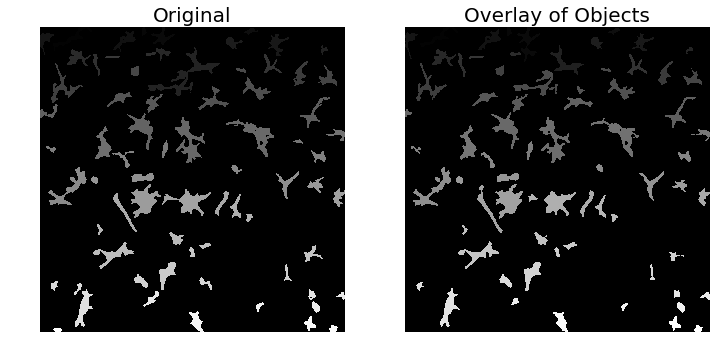

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 7))

axes[0].imshow(label_stack[1], cmap='gray')
axes[0].set_title('Original', fontsize='20')

axes[1].imshow(label_stack[2], cmap='gray')
axes[1].set_title('Overlay of Objects', fontsize='20')

for ax in axes:
    ax.axis('off')

In [6]:
frames = []

#Create data frame called frames that has the image number labelled.
for i in range(len(label_stack)):
    frames.append(props.im_properties(label_stack[i], im_stack[i]))
    frames[i]['Image number'] = i

    #concatenate all the data into one big data frame
df = pd.concat(frames)

In [7]:
def dist(a, b):
    v = ((b[0]-a[0])**2 + (b[1]-a[1])**2)**.5
    return v

# initialize cell number to an invalid value
df['cell'] = -1
# sort by image num, so can iter over whole df in order easily
df = df.sort_values('Image number', ascending = [1]).reset_index()

# figure out what cross sections are in the same cells
for j, r in df.iterrows():
    # get center of current cross section
    r_cent = [r['centroid-0'], r['centroid-1']]
    # get centers of cross sections in prev slice
    prev = df[df['Image number'] == r['Image number']-1]
    # get cross sections from prev slice that are "close" to current cross section
    # TODO fix threshold, possibly generated by code?
    close = prev[(dist(r_cent, [prev['centroid-0'], prev['centroid-1']]) < 20)]
    # if there cross section close to current, current probably part of same cell
    if not close.empty:
        # TODO come up with a smarter way to choose which cell part of, maybe closest?
        # choose an arbitrary close cell to be part of
        df['cell'].iat[j] = close['cell'].min()
    else:
        # otherwise, is a new cell, so give it a new cell number
        df['cell'].iat[j] = df['cell'].max()+1
        

df['cell'].max()

149

In [8]:
df.head()

,index,area,major_axis_length,minor_axis_length,mean_intensity,eccentricity,extent,coords,centroid-0,centroid-1,Image number,cell
0,0,5552,204.933557,127.697463,1500.203710,0.782129,0.239910,"[[0, 142], [0, 143], [0, 144], [0, 145], [0, 1...",61,86,0,0
1,36,457,28.679028,20.330409,3237.280088,0.705314,0.731200,"[[501, 177], [501, 178], [501, 179], [501, 180...",512,183,0,1
2,37,1500,59.320729,45.899364,1345.948000,0.633492,0.439110,"[[502, 951], [502, 952], [503, 947], [503, 948...",529,926,0,2
3,38,5301,102.394508,82.811936,2333.399925,0.588147,0.446325,"[[527, 366], [527, 367], [527, 368], [527, 369...",582,350,0,3
4,39,259,23.686428,14.200065,1823.822394,0.800373,0.674479,"[[530, 257], [530, 258], [530, 259], [531, 255...",540,256,0,4


In [9]:
df.tail()

,index,area,major_axis_length,minor_axis_length,mean_intensity,eccentricity,extent,coords,centroid-0,centroid-1,Image number,cell
1038,1,902,93.460856,20.480229,1063.305987,0.975695,0.217664,"[[57, 172], [57, 173], [58, 171], [58, 172], [...",89,202,20,39
1039,0,324,40.675819,10.872190,1190.444444,0.963616,0.729730,"[[0, 316], [0, 317], [0, 318], [1, 314], [1, 3...",17,315,20,45
1040,26,370,23.901608,19.930585,4247.313514,0.551977,0.734127,"[[757, 371], [757, 372], [758, 368], [758, 369...",768,371,20,144
1041,12,1022,55.641982,27.230856,1489.614481,0.872063,0.480263,"[[302, 490], [302, 491], [302, 492], [303, 489...",321,516,20,131
1042,27,1833,85.634390,32.582338,2103.254774,0.924788,0.585249,"[[759, 326], [759, 327], [760, 325], [760, 326...",801,327,20,116


In [10]:
df['coords'][1039]

array([[  0, 316],
       [  0, 317],
       [  0, 318],
       [  1, 314],
       [  1, 315],
       [  1, 316],
       [  1, 317],
       [  1, 318],
       [  1, 319],
       [  1, 320],
       [  2, 313],
       [  2, 314],
       [  2, 315],
       [  2, 316],
       [  2, 317],
       [  2, 318],
       [  2, 319],
       [  2, 320],
       [  2, 321],
       [  3, 312],
       [  3, 313],
       [  3, 314],
       [  3, 315],
       [  3, 316],
       [  3, 317],
       [  3, 318],
       [  3, 319],
       [  3, 320],
       [  3, 321],
       [  4, 312],
       [  4, 313],
       [  4, 314],
       [  4, 315],
       [  4, 316],
       [  4, 317],
       [  4, 318],
       [  4, 319],
       [  4, 320],
       [  4, 321],
       [  4, 322],
       [  5, 312],
       [  5, 313],
       [  5, 314],
       [  5, 315],
       [  5, 316],
       [  5, 317],
       [  5, 318],
       [  5, 319],
       [  5, 320],
       [  5, 321],
       [  6, 312],
       [  6, 313],
       [  6,

In [11]:
new_df = np.vstack(df['coords'])

In [12]:
list(zip(*new_df))[0]

(0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,


In [13]:
lens = [len(item) for item in df['coords']]
len(lens)
df_out = pd.DataFrame({"Image number" : np.repeat(df['Image number'].values,lens), 
               "coords x" : list(zip(*new_df))[0],
                      "coords y":list(zip(*new_df))[1]})


In [14]:
import mayavi
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


In [ ]:
mlab.clf()
mlab.points3d(df_out['coords x'], df_out['coords y'], df_out['Image number'], scale_factor = 20)

In [ ]:
mlab.clf()
mlab.points3d(df['centroid-0'], df['centroid-1'], df['Image number'], scale_factor = 20)
